# Initial Setup

In [1]:
!pip install arviz

     |████████████████████████████████| 1.5MB 4.2MB/s 
     |████████████████████████████████| 737kB 24.8MB/s 
     |████████████████████████████████| 4.7MB 34.8MB/s 
     |████████████████████████████████| 296kB 52.0MB/s 
  Found existing installation: xarray 0.15.1
    Uninstalling xarray-0.15.1:
      Successfully uninstalled xarray-0.15.1


In [2]:
!pip install pymc3==3.8

     |████████████████████████████████| 911kB 6.1MB/s 
  Found existing installation: pymc3 3.7
    Uninstalling pymc3-3.7:
      Successfully uninstalled pymc3-3.7


In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pymc3 as pm
import pandas as pd
import theano

import itertools

plt.style.use('bmh')
plt.rcParams["figure.figsize"] = (8,5)

In [4]:
SEED = 42
np.random.seed(SEED)

In [5]:
data = pd.read_csv('mlmldata.csv')
data.head()

,schid,stuid,ses,meanses,homework,white,parented,public,ratio,percmin,math,sex,race,sctype,cstr,scsize,urban,region,schnum
0,7472,3,-0.13,-0.482609,1,1,2,1,19,0,48,2,4,1,2,3,2,2,1
1,7472,8,-0.39,-0.482609,0,1,2,1,19,0,48,1,4,1,2,3,2,2,1
2,7472,13,-0.80,-0.482609,0,1,2,1,19,0,53,1,4,1,2,3,2,2,1
3,7472,17,-0.72,-0.482609,1,1,2,1,19,0,42,1,4,1,2,3,2,2,1
4,7472,27,-0.74,-0.482609,2,1,2,1,19,0,43,2,4,1,2,3,2,2,1


In [ ]:
# Helpers

# plot line with slope and intercept
def abline(slope, intercept, ax=None, **kwargs):
    """Plot a line from slope and intercept"""
    axes = ax if ax else plt.gca()
    x_vals = np.array([0,7])
    y_vals = intercept + slope * x_vals
    axes.plot(x_vals, y_vals,  **kwargs)
    
# facet with defaults specific to this data
def facetgrid(func):
    """ func is a function that takes the group df, matplotlib axes, group ID
        func must plot using the axes
    """
    fig, ax = plt.subplots(2, 5, figsize=(16,7), 
                           sharex=True, sharey=True,
                            constrained_layout=True)
    
    groups = data.groupby('schid')  # 10 schools
    grp_ids = list(groups.groups)
    
    for i, j in itertools.product(range(2), range(5)):
        grp_id = grp_ids[i * 5 + j]
        func(groups.get_group(grp_id), ax[i,j], grp_id)
        ax[i,j].set_title('schid : ' + str(grp_id), fontweight='bold')
        
    fig.text(0.5, -0.03, 'homework', ha='center', fontsize=16)
    fig.text(-0.02, 0.5, 'math', va='center', rotation='vertical', fontsize=16)
    handles, labels = ax[-1,-1].get_legend_handles_labels()
    fig.legend(handles, labels, loc='upper right', bbox_to_anchor=(0.98, 0.98))
    
# colors from BMH style
red = '#A60628'
blue = '#0072B2'
green = '#467821'
violet = '#7A68A6'
orange = '#D55E00'
pink = '#CC79A7'

Text(0, 0.5, 'math')

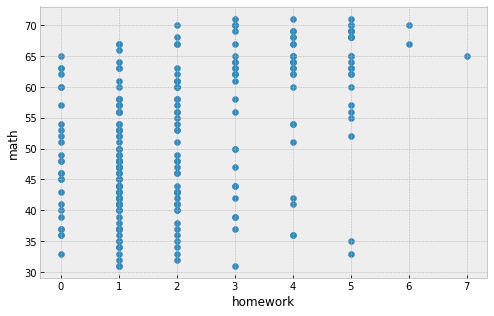

In [ ]:
def plot_data(df, ax=None, grp_id=None, **kwargs):
    if not ax:
        fig, ax = plt.subplots()
    ax.scatter(df['homework'], df['math'], **kwargs)
    return ax
    
ax = plot_data(data)
ax.set_xlabel('homework')
ax.set_ylabel('math')

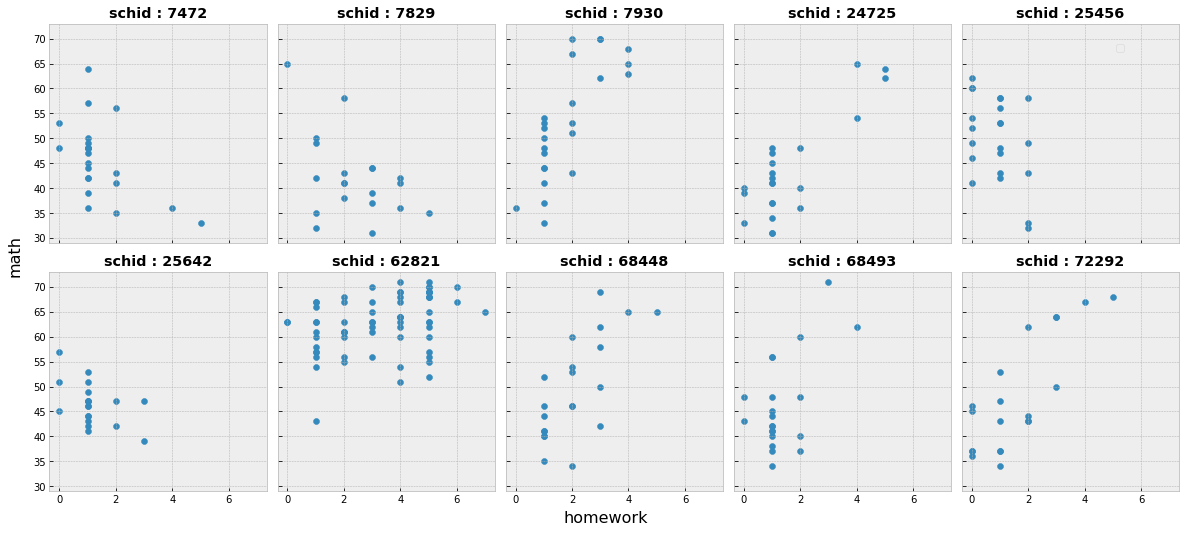

In [ ]:
facetgrid(plot_data)

There is a significant variation in the relationship across different groups. Clearly, a single model will not be able to capture it.

# Pooled linear regression

Let us fit a model on the entire dataset. For simplicity, I will use an ols regression model

In [ ]:
from statsmodels.formula.api import ols

unpooled_model = ols('math ~ homework', data).fit()
unpooled_est = unpooled_model.params

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


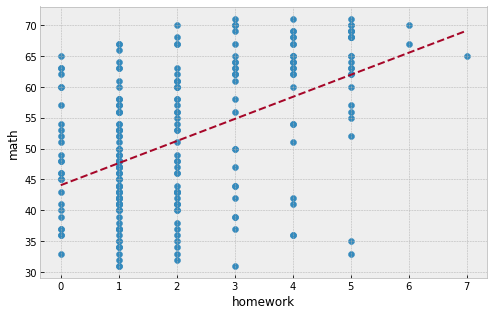

In [ ]:
m = unpooled_est['homework']
c = unpooled_est['Intercept']

plt.scatter(data['homework'], data['math'])
plt.xlabel('homework')
plt.ylabel('math')

abline(m, c, linestyle='--', color=red)

# Unpooled linear regression

We will estimate different parameters for different groups in the data. Again for simplicity, I'm using OLS regression

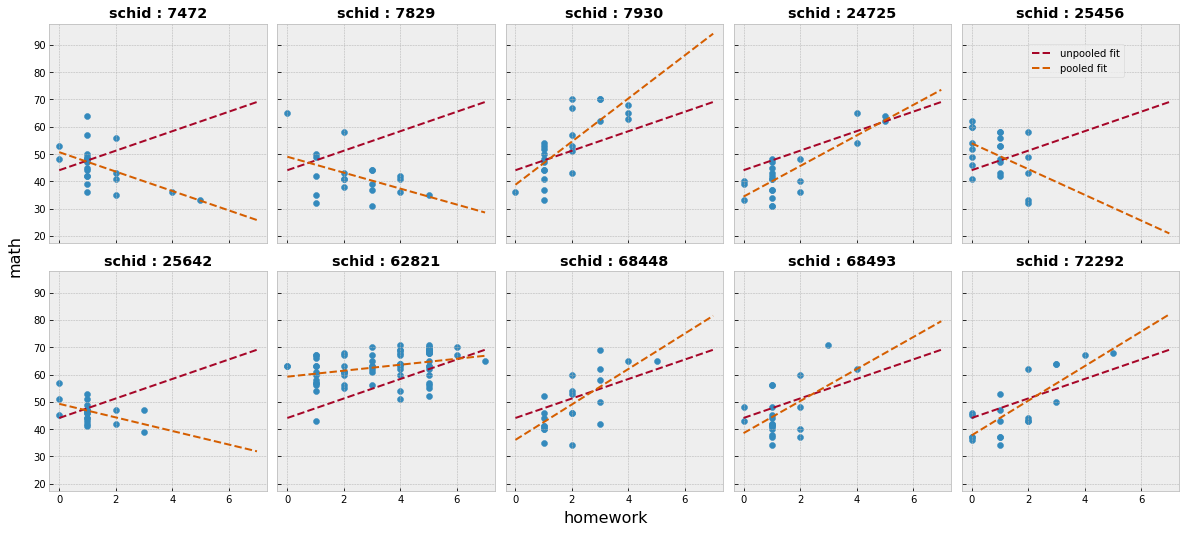

In [ ]:
pooled_est = {}  # scid : (m, c)

def pooled_model(df, ax, grp_id):
    pooled_model = ols('math ~ homework', df).fit()
    pooled_params = pooled_model.params
    
    mp = pooled_params['homework']
    cp = pooled_params['Intercept']
    
    # save estimates of the group
    pooled_est[grp_id] = (mp, cp)
    
    # plot along with unpooled regression line
    plot_data(df, ax, grp_id)
    abline(m, c, ax, linestyle='--', color=red, label='unpooled fit')
    abline(mp, cp, ax, linestyle='--', color=orange, label='pooled fit')
    
facetgrid(pooled_model)

# HLM (Frequentistic inference)

Reference: https://www.statsmodels.org/stable/examples/notebooks/generated/mixed_lm_example.html

In [ ]:
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.tools.sm_exceptions import ConvergenceWarning

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
data = pd.read_csv('mlmldata.csv')
data

,schid,stuid,ses,meanses,homework,white,parented,public,ratio,percmin,math,sex,race,sctype,cstr,scsize,urban,region,schnum
0,7472,3,-0.13,-0.482609,1,1,2,1,19,0,48,2,4,1,2,3,2,2,1
1,7472,8,-0.39,-0.482609,0,1,2,1,19,0,48,1,4,1,2,3,2,2,1
2,7472,13,-0.80,-0.482609,0,1,2,1,19,0,53,1,4,1,2,3,2,2,1
3,7472,17,-0.72,-0.482609,1,1,2,1,19,0,42,1,4,1,2,3,2,2,1
4,7472,27,-0.74,-0.482609,2,1,2,1,19,0,43,2,4,1,2,3,2,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
255,72292,89,-0.23,-0.504500,2,1,3,1,17,1,43,1,4,1,4,2,1,1,10
256,72292,92,-1.11,-0.504500,0,1,1,1,17,1,45,1,4,1,4,2,1,1,10
257,72292,97,-0.29,-0.504500,1,1,3,1,17,1,47,1,4,1,4,2,1,1,10
258,72292,98,-1.19,-0.504500,1,1,1,1,17,1,34,1,4,1,4,2,1,1,10


In [ ]:
data.describe()

,schid,stuid,ses,meanses,homework,white,parented,public,ratio,percmin,math,sex,race,sctype,cstr,scsize,urban,region,schnum
count,260.000000,260.000000,260.000000,260.000000,260.000000,260.000000,260.000000,260.000000,260.000000,260.000000,260.000000,260.000000,260.000000,260.000000,260.000000,260.000000,260.000000,260.000000,260.000000
mean,41023.792308,49.869231,-0.073308,-0.073308,2.023077,0.726923,3.176923,0.742308,14.534615,2.834615,51.300000,1.492308,3.576923,1.773077,3.561538,3.269231,1.773077,2.330769,5.688462
std,25855.919595,28.943398,0.970435,0.726422,1.549519,0.446399,1.516781,0.438207,3.947869,2.265989,11.135633,0.500905,0.779718,1.314622,0.761058,1.377079,0.929174,0.613723,2.676774
min,7472.000000,0.000000,-2.410000,-1.068500,0.000000,0.000000,1.000000,0.000000,10.000000,0.000000,31.000000,1.000000,1.000000,1.000000,2.000000,2.000000,1.000000,1.000000,1.000000
25%,7930.000000,24.750000,-0.770000,-0.504500,1.000000,0.000000,2.000000,0.000000,10.000000,1.000000,42.000000,1.000000,3.000000,1.000000,3.000000,2.000000,1.000000,2.000000,3.000000
50%,25642.000000,52.000000,-0.145000,-0.196818,1.000000,1.000000,3.000000,1.000000,14.000000,3.000000,49.500000,1.000000,4.000000,1.000000,4.000000,3.000000,1.000000,2.000000,6.000000
75%,62821.000000,73.250000,0.812500,1.044627,3.000000,1.000000,4.000000,1.000000,18.000000,5.000000,62.000000,2.000000,4.000000,4.000000,4.000000,3.250000,3.000000,3.000000,7.000000
max,72292.000000,99.000000,1.850000,1.044627,7.000000,1.000000,6.000000,1.000000,22.000000,7.000000,71.000000,2.000000,4.000000,4.000000,5.000000,6.000000,3.000000,3.000000,10.000000


In [ ]:
from sklearn.preprocessing import LabelEncoder

sch_le = LabelEncoder()

school = sch_le.fit_transform(data['schid'])
n_schools = len(sch_le.classes_)
n_schools

10

In [ ]:
data['school'] = school

In [ ]:
df_for_r = data[['school','math','homework']]

In [ ]:
df_for_r.to_csv('df_for_r_hlm.csv')

In [ ]:
endog = data['math']
data['Intercept'] = 1
exog = data[['Intercept', 'homework']]

In [ ]:
md = sm.MixedLM(endog, exog, groups=school, exog_re = exog.copy())
mdf = md.fit()
print(mdf.summary())

# Scale = residual variance

               Mixed Linear Model Regression Results
Model:                 MixedLM     Dependent Variable:     math     
No. Observations:      260         Method:                 REML     
No. Groups:            10          Scale:                  43.0710  
Min. group size:       20          Likelihood:             -881.9772
Max. group size:       67          Converged:              Yes      
Mean group size:       26.0                                         
--------------------------------------------------------------------
                          Coef.  Std.Err.   z    P>|z| [0.025 0.975]
--------------------------------------------------------------------
Intercept                 44.771    2.744 16.314 0.000 39.392 50.149
homework                   2.040    1.555  1.312 0.190 -1.008  5.089
Intercept Var             69.304    5.437                           
Intercept x homework Cov -31.762    2.812                           
homework Var              22.453    1.787         

In [ ]:
# ICC = Interclass Variance / Total Variance

# HLM (with Bayesian Inference)

Reference: 

https://towardsdatascience.com/introduction-to-hierarchical-modeling-a5c7b2ebb1ca

https://towardsdatascience.com/estimating-probabilities-with-bayesian-modeling-in-python-7144be007815

https://towardsdatascience.com/hands-on-bayesian-statistics-with-python-pymc3-arviz-499db9a59501

## Partial pooling

We will perform bayesian hierarchical modeling using PyMC3. We will construct hyper priors on our group level parameters to allow the model to share student level coefficients among the groups withing the data. The model can be represented as:

$$ y_i = \alpha_{ji} + \beta_{ji}x_i + \epsilon_i $$

or in probabilistic notation:

$$ y \sim N(\alpha_{j} + \beta_{j}x, \epsilon) $$

where j is the school index.

For this model I will use a random slope and intercept, meaning both of them will have an hyper prior on them. 

In [6]:
from sklearn.preprocessing import LabelEncoder

sch_le = LabelEncoder()

school = sch_le.fit_transform(data['schid'])
n_schools = len(sch_le.classes_)
homework = data.homework
math = data.math

### Connections to Frequentist statistics

In [19]:
with pm.Model() as model:
    # Hyperpriors
    fixed_A = pm.Uniform("prior_fixed_A", 30,60)
    random_A = pm.Uniform('prior_random_A', 2,12)
    
    fixed_B = pm.Uniform('prior_fixed_B', 0, 5)
    random_B = pm.Uniform('prior_random_B', 0, 10)
    
    # Intercept
    Intercept = pm.Normal('A', mu=fixed_A, sigma=random_A, shape=n_schools)
    # Slope
    Homework = pm.Normal('B', mu=fixed_B, sigma=random_B, shape=n_schools)
    
    # Model error
    eps = pm.HalfCauchy('eps', 5)
    
    y_hat = Intercept[school] + Homework[school] * homework
    
    # Likelihood
    y_like = pm.Normal('y_likelihood', mu=y_hat, sigma=eps, observed=math)

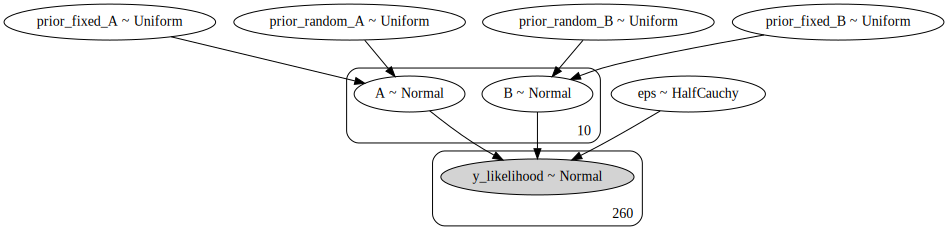

In [20]:
pm.model_to_graphviz(model)

In [16]:
with model:
    step = pm.NUTS()
    trace = pm.sample(10000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [eps, Homework, Intercept, Prior_Random_eff_Homework, Prior_Fixed_eff_Homework, Prior_Random_eff_Intercept, Prior_Fixed_eff_Intercept]
Sampling chain 1, 0 divergences: 100%|██████████| 11000/11000 [00:39<00:00, 278.04it/s]


In [17]:
df_summary = pm.summary(trace)
df_summary

/usr/local/lib/python3.6/dist-packages/arviz/data/io_pymc3.py:91: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
Intercept[0],49.750,2.125,45.624,53.616,0.013,0.009,27038.0,27038.0,27034.0,15088.0,1.0
Intercept[1],47.833,2.860,42.476,53.182,0.018,0.013,25630.0,25601.0,25457.0,15901.0,1.0
Intercept[2],39.930,2.458,35.359,44.601,0.014,0.010,28955.0,28945.0,28952.0,15519.0,1.0
Intercept[3],35.291,2.066,31.539,39.304,0.012,0.009,27649.0,27611.0,27669.0,14881.0,1.0
Intercept[4],52.597,2.044,48.674,56.346,0.012,0.009,28024.0,27797.0,28076.0,14981.0,1.0
Intercept[5],48.179,2.383,43.570,52.573,0.014,0.010,27660.0,27582.0,27657.0,14723.0,1.0
Intercept[6],58.519,1.722,55.284,61.747,0.011,0.008,25164.0,25143.0,25157.0,15395.0,1.0
Intercept[7],37.720,2.866,32.330,43.054,0.018,0.013,25927.0,25657.0,25953.0,15868.0,1.0
Intercept[8],39.580,2.434,35.049,44.206,0.014,0.010,28696.0,28597.0,28674.0,15888.0,1.0
Intercept[9],38.550,2.172,34.464,42.568,0.013,0.009,28761.0,28558.0,28781.0,15134.0,1.0


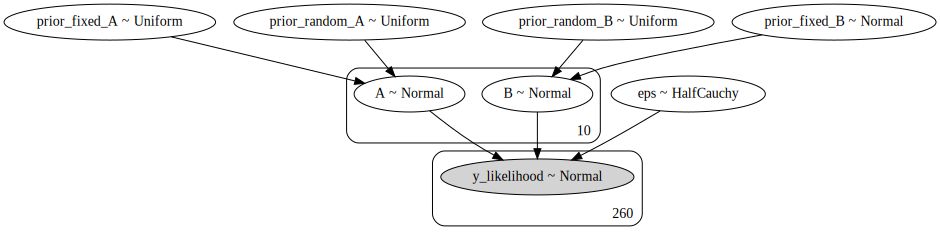

In [23]:
with pm.Model() as model:
    # Hyperpriors
    fixed_A = pm.Uniform("prior_fixed_A", 30,60)
    random_A = pm.Uniform('prior_random_A', 2,12)
    
    fixed_B = pm.Normal('prior_fixed_B', 5, 2) # Manipulation
    random_B = pm.Uniform('prior_random_B', 0, 10)
    
    # Intercept
    Intercept = pm.Normal('A', mu=fixed_A, sigma=random_A, shape=n_schools)
    # Slope
    Homework = pm.Normal('B', mu=fixed_B, sigma=random_B, shape=n_schools)
    
    # Model error
    eps = pm.HalfCauchy('eps', 5)
    
    y_hat = Intercept[school] + Homework[school] * homework
    
    # Likelihood
    y_like = pm.Normal('y_likelihood', mu=y_hat, sigma=eps, observed=math)

pm.model_to_graphviz(model)

In [22]:
with pm.Model() as model:
    # Hyperpriors
    fixed_A = pm.Uniform("prior_fixed_A", 30,60)
    random_A = pm.Uniform('prior_random_A', 2,12)
    
    fixed_B = pm.Normal('prior_fixed_B', 5, 2) # Manipulation
    random_B = pm.Uniform('prior_random_B', 0, 10)
    
    # Intercept
    Intercept = pm.Normal('A', mu=fixed_A, sigma=random_A, shape=n_schools)
    # Slope
    Homework = pm.Normal('B', mu=fixed_B, sigma=random_B, shape=n_schools)
    
    # Model error
    eps = pm.HalfCauchy('eps', 5)
    
    y_hat = Intercept[school] + Homework[school] * homework
    
    # Likelihood
    y_like = pm.Normal('y_likelihood', mu=y_hat, sigma=eps, observed=math)

with model:
    step = pm.NUTS()
    trace = pm.sample(10000, tune=1000)

df_summary = pm.summary(trace)
df_summary

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [eps, B, A, prior_random_B, prior_fixed_B, prior_random_A, prior_fixed_A]
Sampling chain 1, 0 divergences: 100%|██████████| 11000/11000 [00:40<00:00, 274.52it/s]
/usr/local/lib/python3.6/dist-packages/arviz/data/io_pymc3.py:91: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
prior_fixed_B,3.231,1.318,0.850,5.771,0.007,0.006,31241.0,23425.0,32085.0,15280.0,1.0
A[0],49.689,2.132,45.613,53.649,0.013,0.009,27912.0,27910.0,27907.0,14524.0,1.0
A[1],47.753,2.888,42.357,53.177,0.018,0.013,26648.0,26553.0,26639.0,15763.0,1.0
A[2],39.800,2.480,35.273,44.607,0.014,0.010,30967.0,30396.0,30917.0,15440.0,1.0
A[3],35.198,2.055,31.395,39.060,0.012,0.009,27452.0,27434.0,27448.0,15997.0,1.0
A[4],52.510,2.031,48.660,56.319,0.012,0.009,26941.0,26871.0,26926.0,15514.0,1.0
A[5],48.089,2.442,43.501,52.628,0.014,0.010,29303.0,29217.0,29307.0,15041.0,1.0
A[6],58.472,1.738,55.174,61.707,0.011,0.008,25072.0,25072.0,25081.0,14781.0,1.0
A[7],37.561,2.863,32.272,42.895,0.018,0.012,26376.0,26376.0,26477.0,13979.0,1.0
A[8],39.428,2.430,34.765,43.996,0.014,0.010,29354.0,29354.0,29378.0,15439.0,1.0


/usr/local/lib/python3.6/dist-packages/arviz/data/io_pymc3.py:91: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f4d8a75fb38>,
      dtype=object)

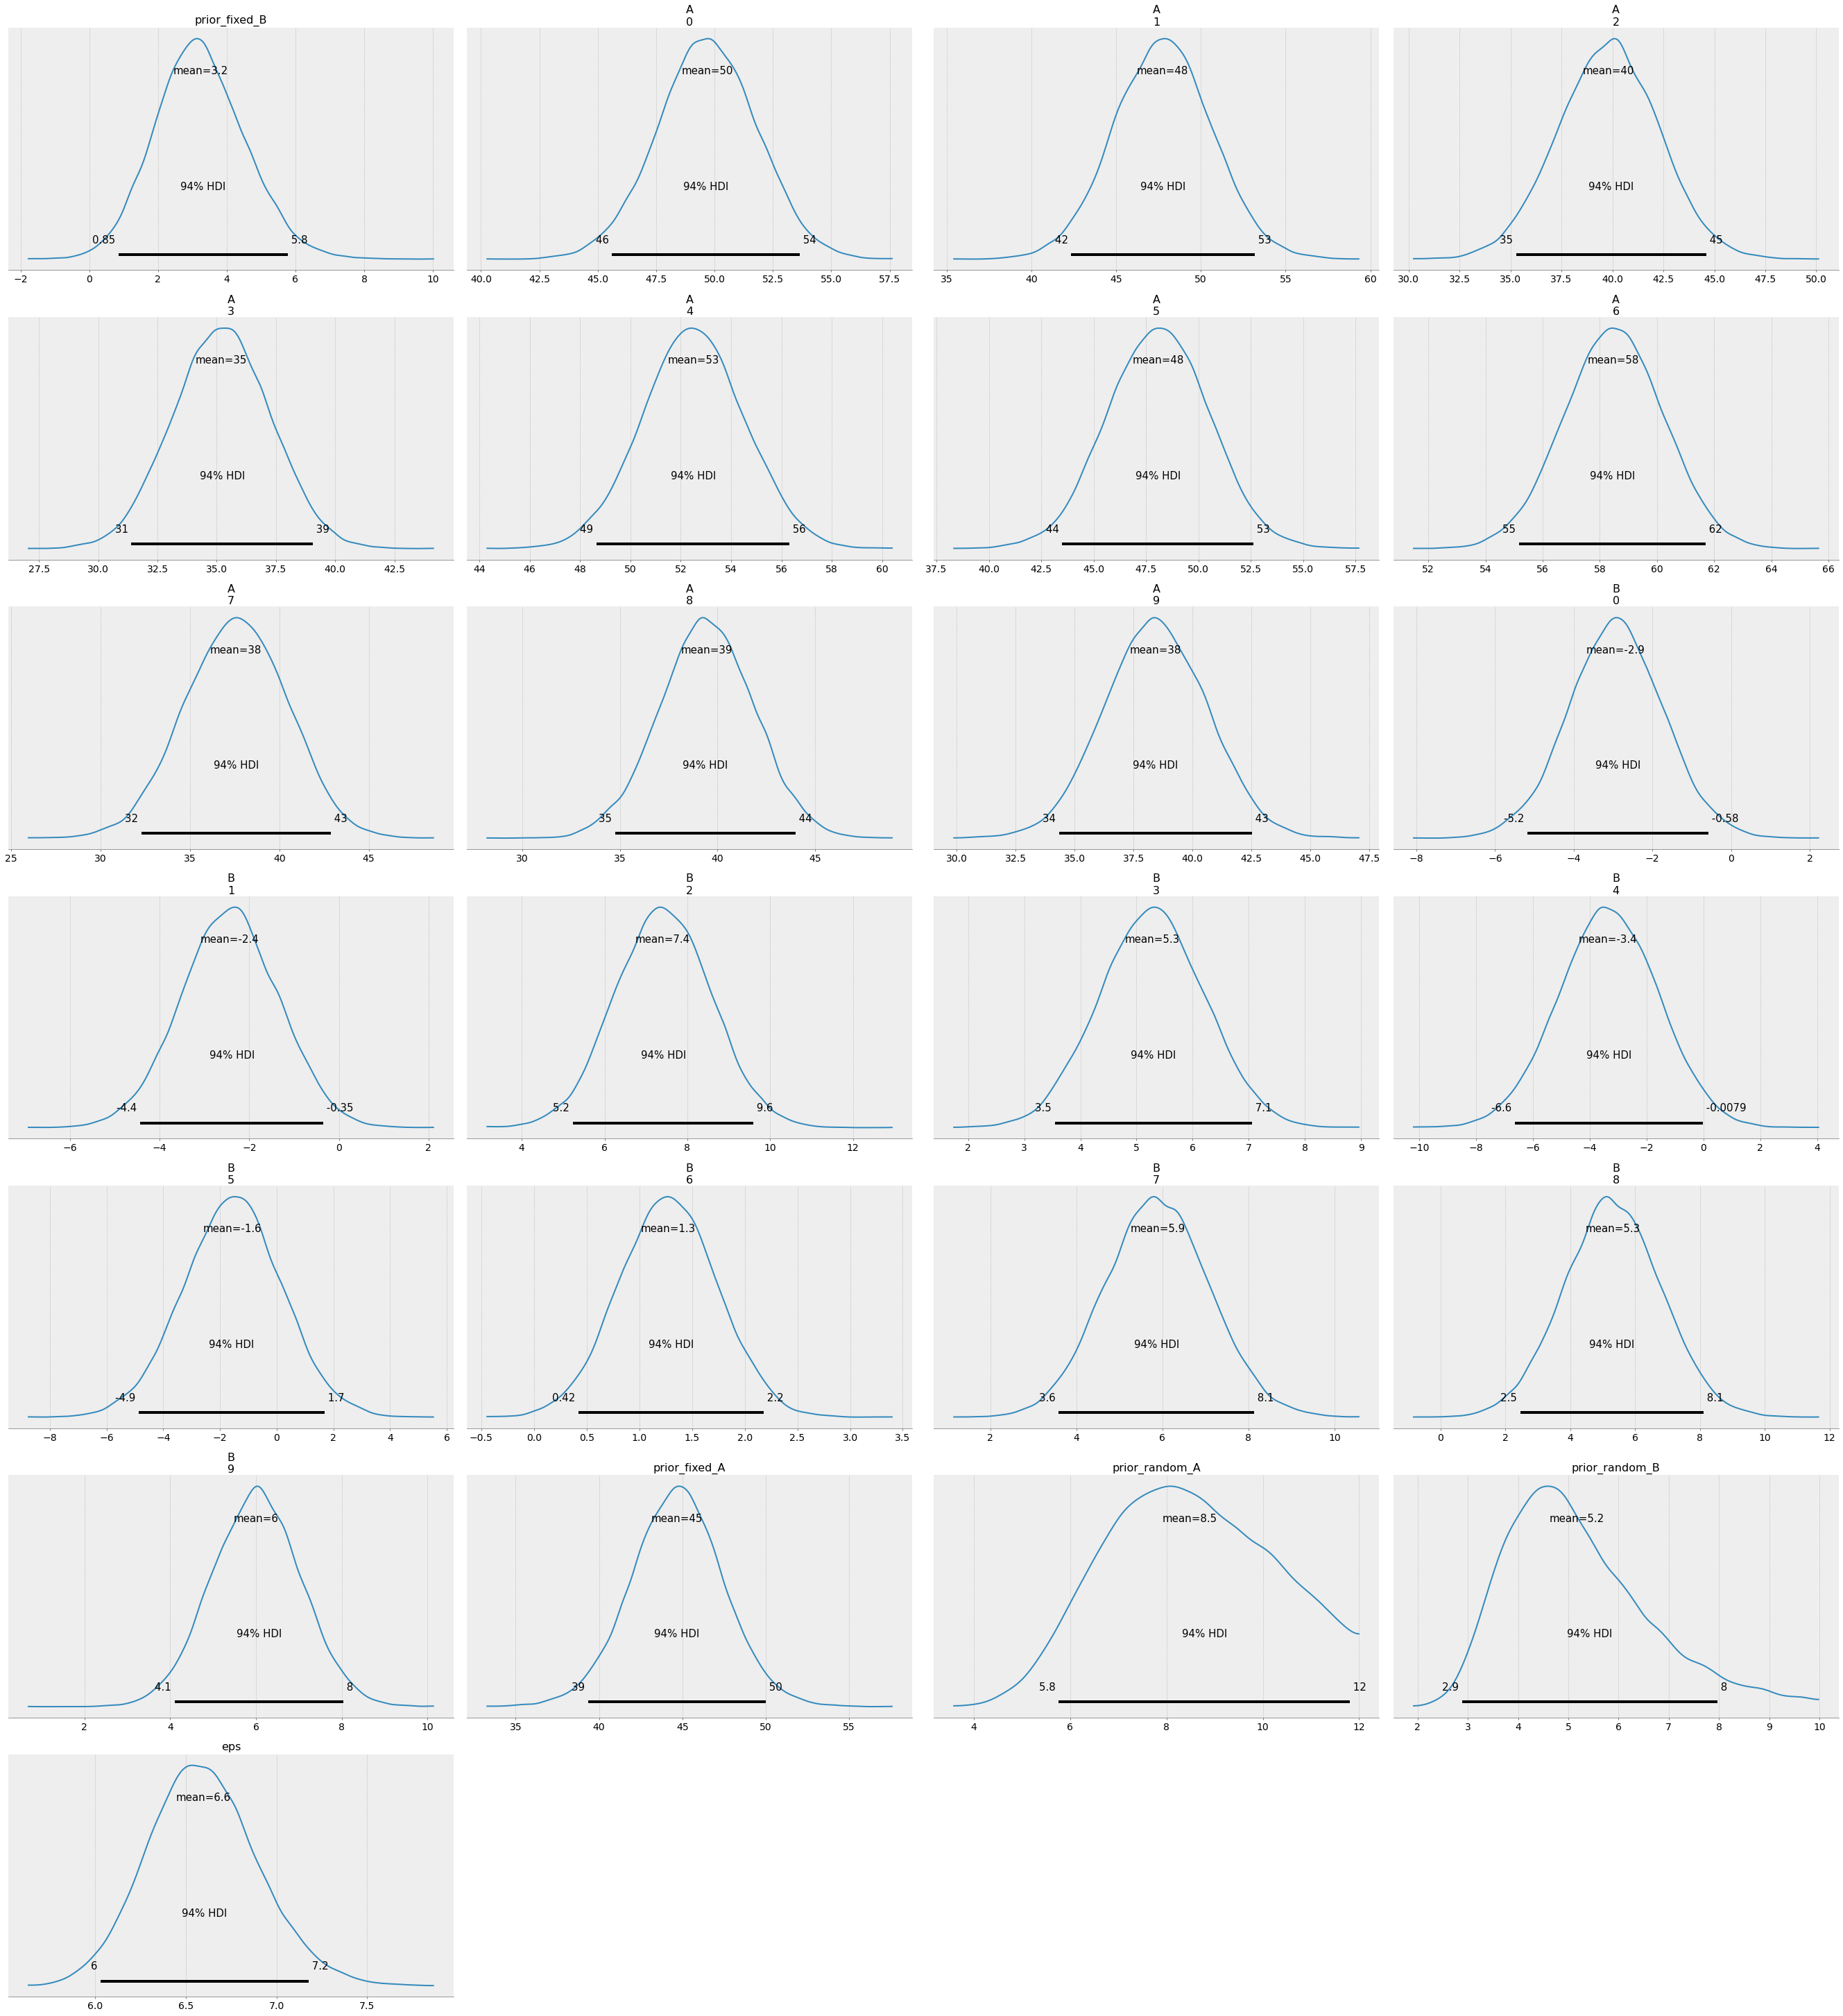

In [24]:
pm.plot_posterior(trace)

### Typical Bayesian

In [ ]:
with pm.Model() as model:
    # Hyperpriors
    mu_a = pm.Normal('mu_a', mu=20, sigma=8)
    sigma_a = pm.HalfNormal('sigma_a', 15)
    
    mu_b = pm.Normal('mu_b', mu=8, sigma=4)
    sigma_b = pm.HalfNormal('sigma_b', 2)
    
    # Intercept
    a = pm.Normal('a', mu=mu_a, sigma=sigma_a, shape=n_schools)
    # Slope
    b = pm.Normal('b', mu=mu_b, sigma=sigma_b, shape=n_schools)
    
    # Model error
    eps = pm.HalfCauchy('eps', 5)
    
    y_hat = a[school] + b[school] * homework
    
    # Likelihood
    y_like = pm.Normal('y_like', mu=y_hat, sigma=eps, observed=math)

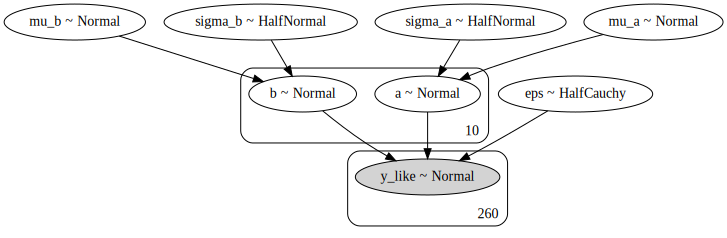

In [ ]:
pm.model_to_graphviz(model)

Let's run inference with NUTS sampler for the model above

In [ ]:
with model:
    step = pm.NUTS()
    trace = pm.sample(2000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [eps, b, a, sigma_b, mu_b, sigma_a, mu_a]
Sampling chain 1, 0 divergences: 100%|██████████| 3000/3000 [00:09<00:00, 313.37it/s]


### Posterior distributions

/usr/local/lib/python3.6/dist-packages/arviz/data/io_pymc3.py:91: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f76051f6b38>,
      dtype=object)

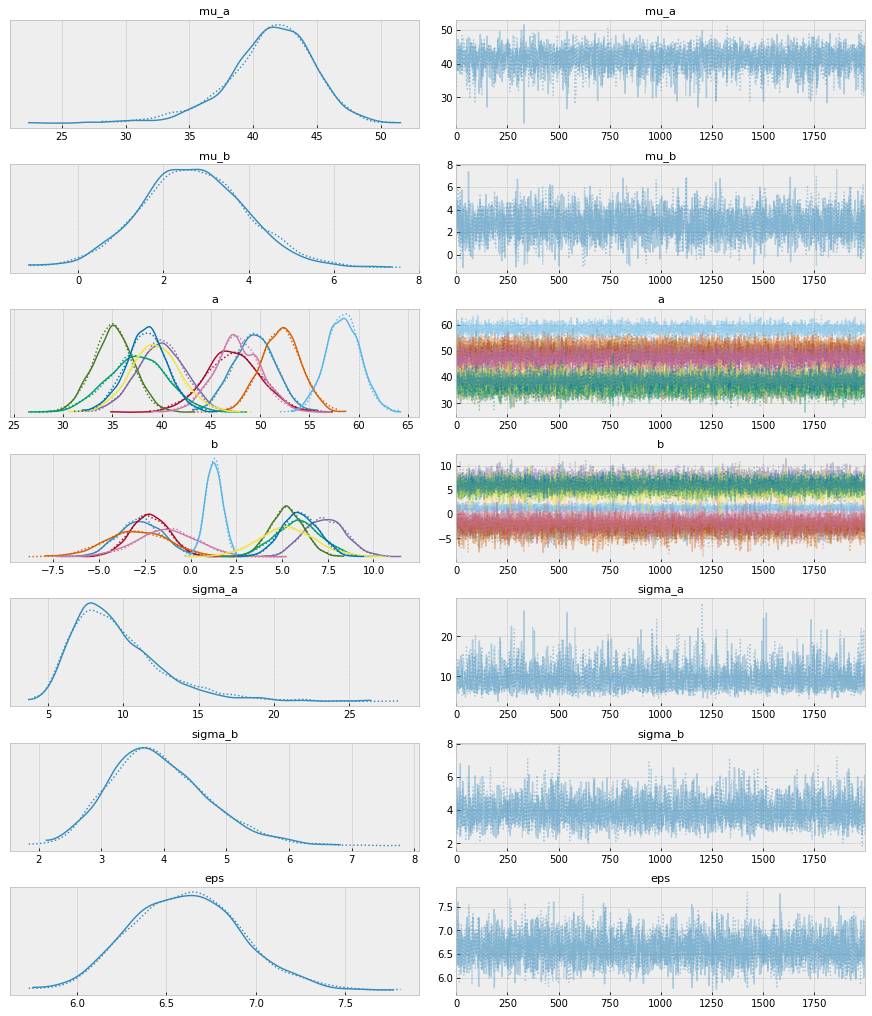

In [ ]:
pm.traceplot(trace)

In [ ]:
df_summary = pm.summary(trace)
df_summary

/usr/local/lib/python3.6/dist-packages/arviz/data/io_pymc3.py:91: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
mu_a,41.446,3.303,35.041,46.898,0.052,0.037,4051.0,4051.0,4724.0,2665.0,1.0
mu_b,2.710,1.287,0.342,5.275,0.018,0.014,5263.0,4526.0,5342.0,3291.0,1.0
a[0],49.292,2.236,44.949,53.323,0.028,0.020,6169.0,6169.0,6199.0,3073.0,1.0
a[1],47.252,2.746,42.335,52.440,0.033,0.024,6788.0,6755.0,6778.0,3135.0,1.0
a[2],39.907,2.419,35.356,44.408,0.034,0.024,5166.0,5131.0,5153.0,3288.0,1.0
a[3],35.068,2.022,31.230,38.724,0.025,0.018,6398.0,6372.0,6390.0,3316.0,1.0
a[4],52.108,2.029,48.375,56.011,0.028,0.020,5375.0,5375.0,5385.0,3030.0,1.0
a[5],47.651,2.363,43.089,51.962,0.035,0.024,4657.0,4652.0,4566.0,2813.0,1.0
a[6],58.451,1.726,55.494,61.874,0.025,0.018,4686.0,4686.0,4689.0,2850.0,1.0
a[7],37.521,2.899,31.585,42.405,0.038,0.027,5788.0,5704.0,5737.0,3173.0,1.0


/usr/local/lib/python3.6/dist-packages/arviz/data/io_pymc3.py:91: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f7600271dd8>,
      dtype=object)

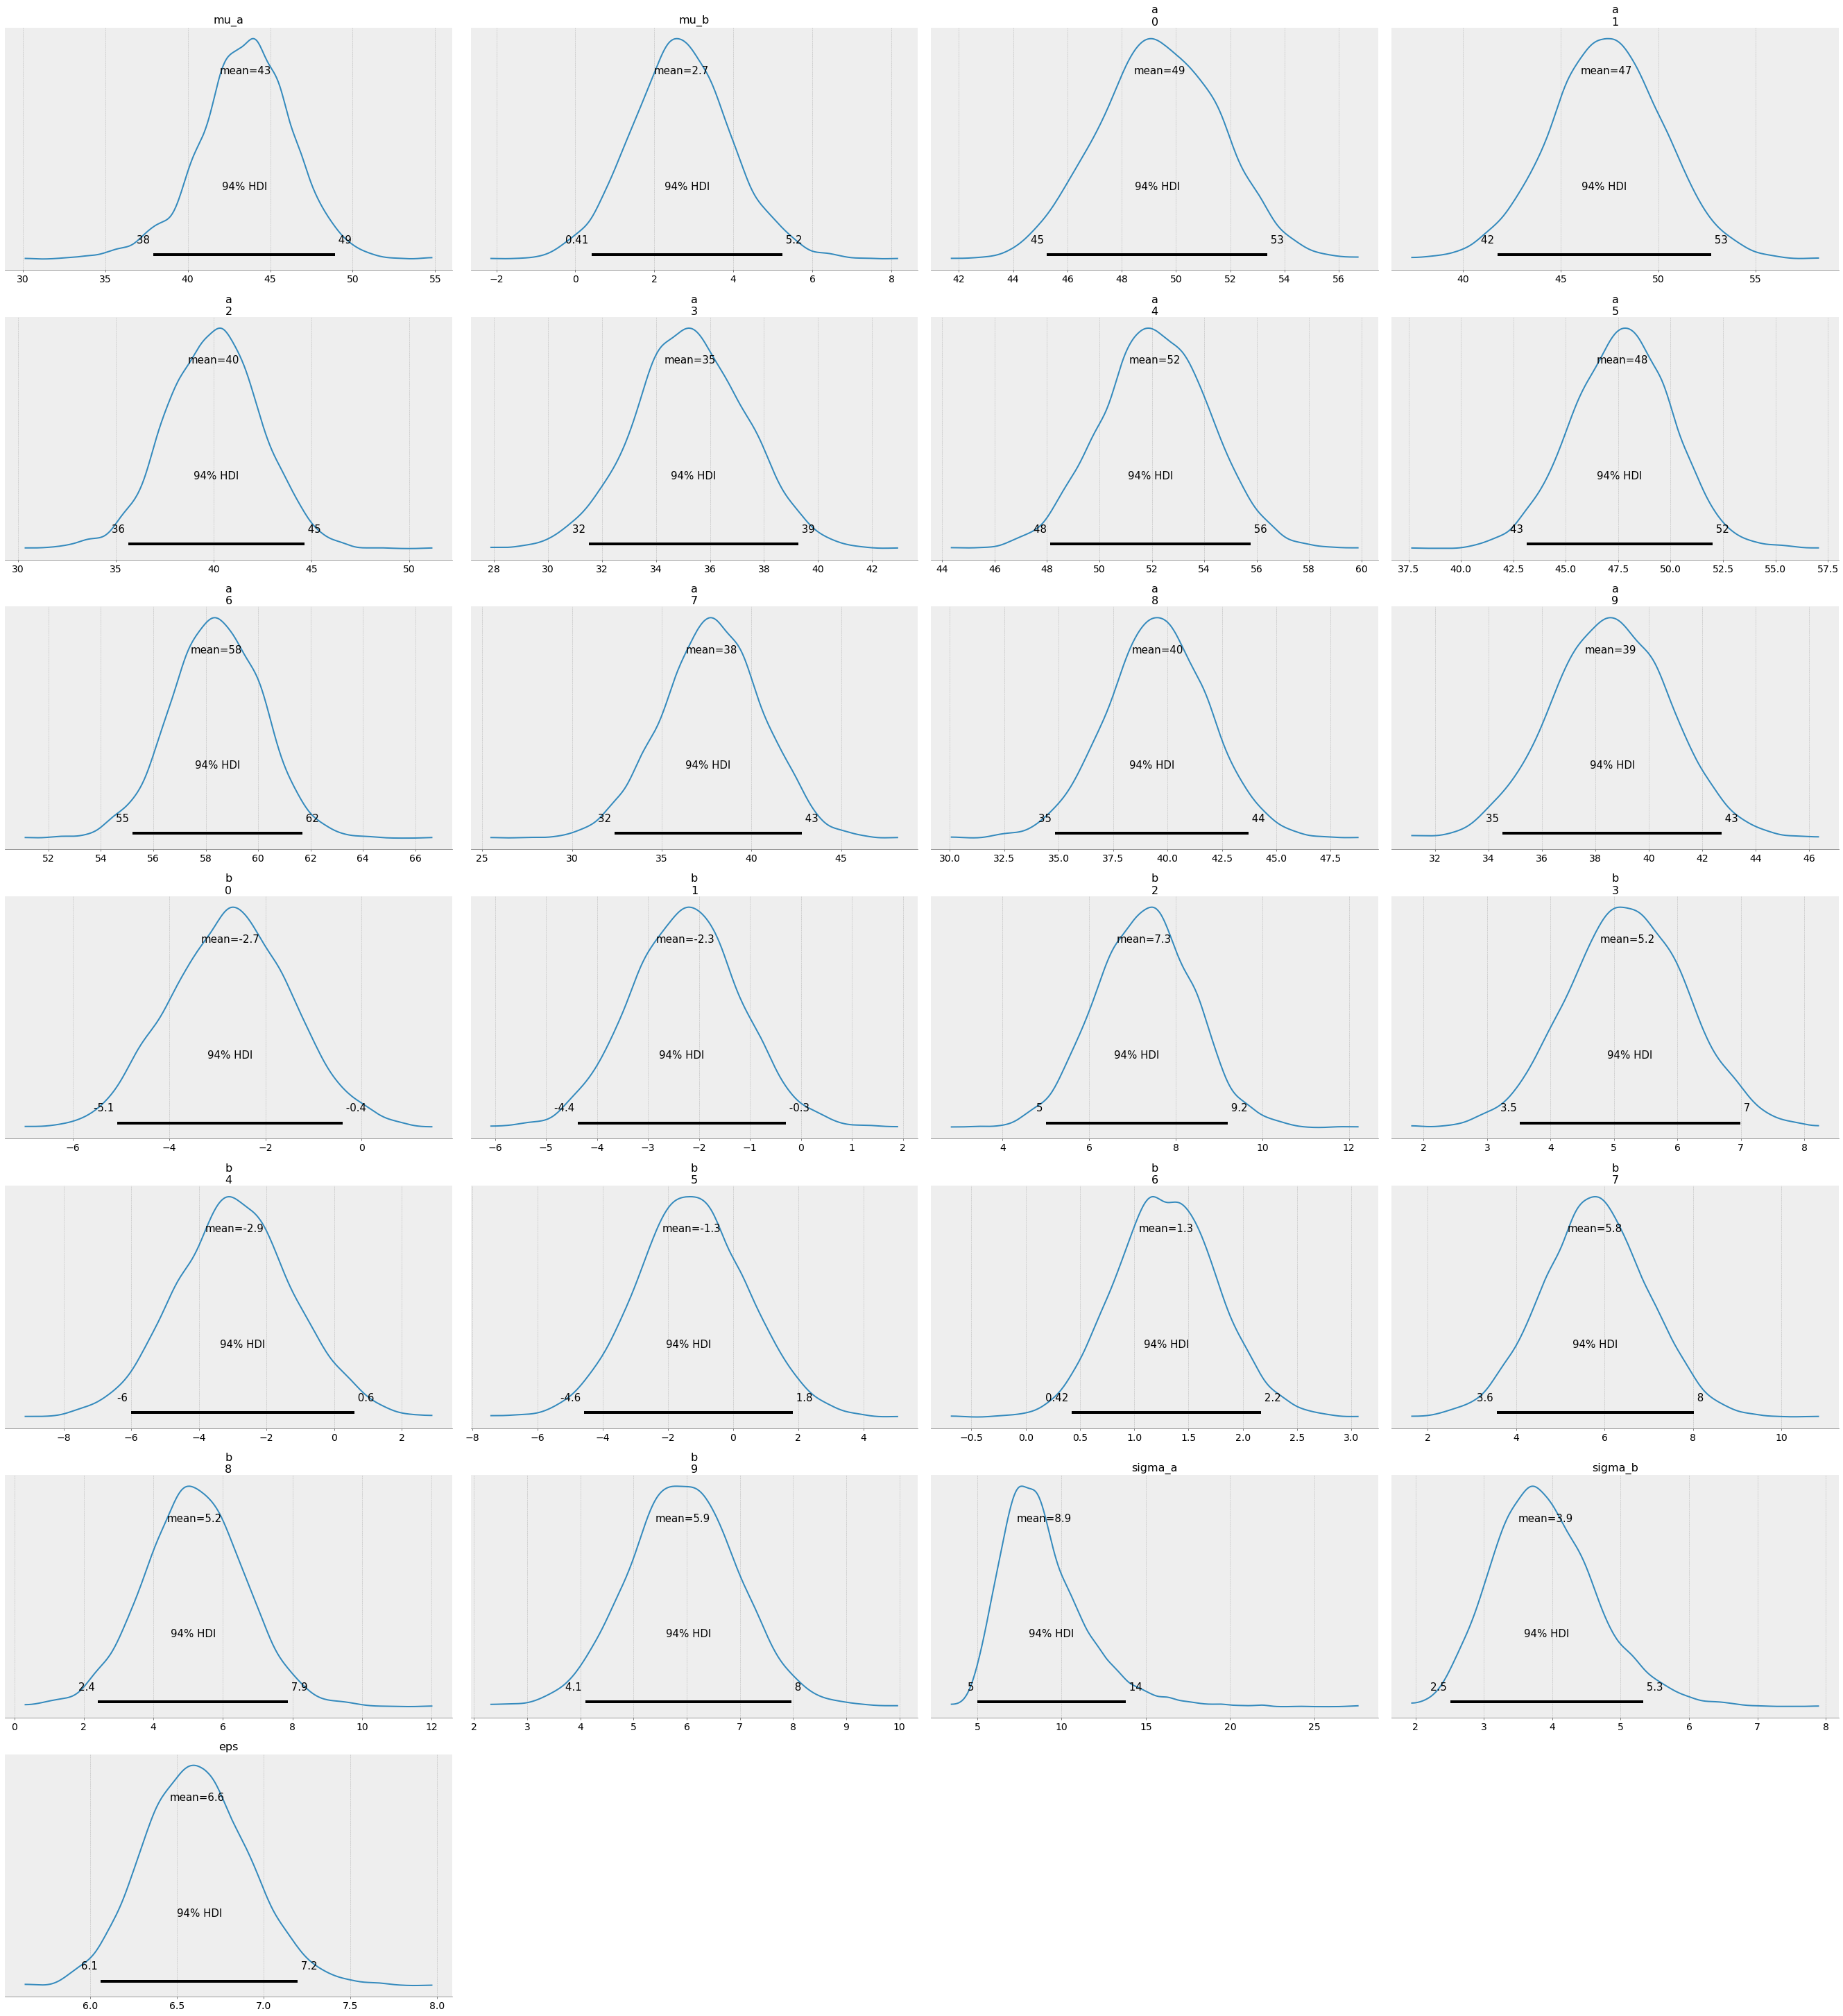

In [ ]:
pm.plot_posterior(trace)

In [ ]:
fixed_eff_prev = np.array([[1,1]])
for i in range (2,20,5):
  with pm.Model() as model:
    # Hyperpriors
    mu_a = pm.Normal('mu_a', mu=20, sigma=8)
    sigma_a = pm.HalfNormal('sigma_a', 15)
    
    mu_b = pm.Normal('mu_b', mu=8, sigma=4)
    sigma_b = pm.HalfNormal('sigma_b', i)
    
    # Intercept
    a = pm.Normal('a', mu=mu_a, sigma=sigma_a, shape=n_schools)
    # Slope
    b = pm.Normal('b', mu=mu_b, sigma=sigma_b, shape=n_schools)
    
    # Model error
    eps = pm.HalfCauchy('eps', 5)
    
    y_hat = a[school] + b[school] * homework
    
    # Likelihood
    y_like = pm.Normal('y_like', mu=y_hat, sigma=eps, observed=math)

  with model:
    step = pm.NUTS()
    trace = pm.sample(2000, tune=1000)

  pm.plot_posterior(trace)


Output hidden; open in https://colab.research.google.com to view.

In [ ]:
for i in range (15,40,5):
  with pm.Model() as model:
    # Hyperpriors
    mu_a = pm.Normal('mu_a', mu=20, sigma=8)
    sigma_a = pm.HalfNormal('sigma_a', i)
    
    mu_b = pm.Normal('mu_b', mu=8, sigma=4)
    sigma_b = pm.HalfNormal('sigma_b', 2)
    
    # Intercept
    a = pm.Normal('a', mu=mu_a, sigma=sigma_a, shape=n_schools)
    # Slope
    b = pm.Normal('b', mu=mu_b, sigma=sigma_b, shape=n_schools)
    
    # Model error
    eps = pm.HalfCauchy('eps', 5)
    
    y_hat = a[school] + b[school] * homework
    
    # Likelihood
    y_like = pm.Normal('y_like', mu=y_hat, sigma=eps, observed=math)

  with model:
    step = pm.NUTS()
    trace = pm.sample(2000, tune=1000)

  pm.plot_posterior(trace)

Output hidden; open in https://colab.research.google.com to view.

In [21]:
for i in range (8,30,5):
  with pm.Model() as model:
    # Hyperpriors
    mu_a = pm.Normal('mu_a', mu=20, sigma=i)
    sigma_a = pm.HalfNormal('sigma_a', 15)
    
    mu_b = pm.Normal('mu_b', mu=8, sigma=4)
    sigma_b = pm.HalfNormal('sigma_b', 2)
    
    # Intercept
    a = pm.Normal('a', mu=mu_a, sigma=sigma_a, shape=n_schools)
    # Slope
    b = pm.Normal('b', mu=mu_b, sigma=sigma_b, shape=n_schools)
    
    # Model error
    eps = pm.HalfCauchy('eps', 5)
    
    y_hat = a[school] + b[school] * homework
    
    # Likelihood
    y_like = pm.Normal('y_like', mu=y_hat, sigma=eps, observed=math)

  with model:
    step = pm.NUTS()
    trace = pm.sample(2000, tune=1000)

  pm.plot_posterior(trace)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
for i in range (4,20,4):
  with pm.Model() as model:
    # Hyperpriors
    mu_a = pm.Normal('mu_a', mu=20, sigma=8)
    sigma_a = pm.HalfNormal('sigma_a', 15)
    
    mu_b = pm.Normal('mu_b', mu=8, sigma=i)
    sigma_b = pm.HalfNormal('sigma_b', 2)
    
    # Intercept
    a = pm.Normal('a', mu=mu_a, sigma=sigma_a, shape=n_schools)
    # Slope
    b = pm.Normal('b', mu=mu_b, sigma=sigma_b, shape=n_schools)
    
    # Model error
    eps = pm.HalfCauchy('eps', 5)
    
    y_hat = a[school] + b[school] * homework
    
    # Likelihood
    y_like = pm.Normal('y_like', mu=y_hat, sigma=eps, observed=math)

  with model:
    step = pm.NUTS()
    trace = pm.sample(2000, tune=1000)

  pm.plot_posterior(trace)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
for i in range (8,40,5):
  with pm.Model() as model:
    # Hyperpriors
    mu_a = pm.Normal('mu_a', mu=20, sigma=8)
    sigma_a = pm.HalfNormal('sigma_a', 15)
    
    mu_b = pm.Normal('mu_b', mu=i, sigma=4)
    sigma_b = pm.HalfNormal('sigma_b', 2)
    
    # Intercept
    a = pm.Normal('a', mu=mu_a, sigma=sigma_a, shape=n_schools)
    # Slope
    b = pm.Normal('b', mu=mu_b, sigma=sigma_b, shape=n_schools)
    
    # Model error
    eps = pm.HalfCauchy('eps', 5)
    
    y_hat = a[school] + b[school] * homework
    
    # Likelihood
    y_like = pm.Normal('y_like', mu=y_hat, sigma=eps, observed=math)

  with model:
    step = pm.NUTS()
    trace = pm.sample(2000, tune=1000)

  pm.plot_posterior(trace)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
for i in range (20,40,5):
  with pm.Model() as model:
    # Hyperpriors
    mu_a = pm.Normal('mu_a', mu=i, sigma=8)
    sigma_a = pm.HalfNormal('sigma_a', 15)
    
    mu_b = pm.Normal('mu_b', mu=8, sigma=4)
    sigma_b = pm.HalfNormal('sigma_b', 2)
    
    # Intercept
    a = pm.Normal('a', mu=mu_a, sigma=sigma_a, shape=n_schools)
    # Slope
    b = pm.Normal('b', mu=mu_b, sigma=sigma_b, shape=n_schools)
    
    # Model error
    eps = pm.HalfCauchy('eps', 5)
    
    y_hat = a[school] + b[school] * homework
    
    # Likelihood
    y_like = pm.Normal('y_like', mu=y_hat, sigma=eps, observed=math)

  with model:
    step = pm.NUTS()
    trace = pm.sample(2000, tune=1000)

  pm.plot_posterior(trace)




Output hidden; open in https://colab.research.google.com to view.

In [ ]:
for i in range (20,40,5):
  with pm.Model() as model:
    # Hyperpriors
    mu_a = pm.Normal('mu_a', mu=i, sigma=8)
    sigma_a = pm.HalfNormal('sigma_a', 15)
    
    mu_b = pm.Normal('mu_b', mu=8, sigma=4)
    sigma_b = pm.HalfNormal('sigma_b', 2)
    
    # Intercept
    a = pm.Normal('a', mu=mu_a, sigma=sigma_a, shape=n_schools)
    # Slope
    b = pm.Normal('b', mu=mu_b, sigma=sigma_b, shape=n_schools)
    
    # Model error
    eps = pm.HalfCauchy('eps', 5)
    
    y_hat = a[school] + b[school] * homework
    
    # Likelihood
    y_like = pm.Normal('y_like', mu=y_hat, sigma=eps, observed=math)

  with model:
    step = pm.NUTS()
    trace = pm.sample(2000, tune=1000)

  df_summary = pm.summary(trace)

  fixed_eff_intercept_posterior = np.mean(df_summary.iloc[2:12,0])
  fixed_eff_slope_posterior = np.mean(df_summary.iloc[12:22,0])
  fixed_eff = np.array([fixed_eff_intercept_posterior,fixed_eff_slope_posterior])
  print(fixed_eff)
  fixed_eff = np.expand_dims(fixed_eff,axis=0)
  fixed_eff_prev = np.concatenate((fixed_eff_prev,fixed_eff))
  print(fixed_eff_prev)

fixed_eff_prev

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [eps, b, a, sigma_b, mu_b, sigma_a, mu_a]
Sampling chain 1, 0 divergences: 100%|██████████| 3000/3000 [00:09<00:00, 304.52it/s]
/usr/local/lib/python3.6/dist-packages/arviz/data/io_pymc3.py:91: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


[44.5199  2.1834]
[[ 1.      1.    ]
 [44.5054  2.1934]
 [44.5093  2.1695]
 [44.5143  2.1551]
 [44.5134  2.1614]
 [44.5157  2.1551]
 [44.5365  2.152 ]
 [44.5269  2.1463]
 [44.5302  2.1493]
 [44.5215  2.1458]
 [44.5287  2.1789]
 [44.4818  2.1991]
 [44.4929  2.195 ]
 [44.5052  2.1907]
 [44.5029  2.1827]
 [44.4902  2.1891]
 [44.6368  2.138 ]
 [44.6697  2.1196]
 [44.513   2.1868]
 [44.5634  2.1495]
 [44.5884  2.1389]
 [44.577   2.1424]
 [44.5156  2.185 ]
 [44.439   2.236 ]
 [44.3622  2.2801]
 [44.2789  2.3258]
 [44.2385  2.3569]
 [44.1822  2.3896]
 [44.1325  2.4032]
 [44.5199  2.1834]]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [eps, b, a, sigma_b, mu_b, sigma_a, mu_a]
Sampling chain 1, 0 divergences: 100%|██████████| 3000/3000 [00:09<00:00, 313.53it/s]
/usr/local/lib/python3.6/dist-packages/arviz/data/io_pymc3.py:91: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


[44.5629  2.1624]
[[ 1.      1.    ]
 [44.5054  2.1934]
 [44.5093  2.1695]
 [44.5143  2.1551]
 [44.5134  2.1614]
 [44.5157  2.1551]
 [44.5365  2.152 ]
 [44.5269  2.1463]
 [44.5302  2.1493]
 [44.5215  2.1458]
 [44.5287  2.1789]
 [44.4818  2.1991]
 [44.4929  2.195 ]
 [44.5052  2.1907]
 [44.5029  2.1827]
 [44.4902  2.1891]
 [44.6368  2.138 ]
 [44.6697  2.1196]
 [44.513   2.1868]
 [44.5634  2.1495]
 [44.5884  2.1389]
 [44.577   2.1424]
 [44.5156  2.185 ]
 [44.439   2.236 ]
 [44.3622  2.2801]
 [44.2789  2.3258]
 [44.2385  2.3569]
 [44.1822  2.3896]
 [44.1325  2.4032]
 [44.5199  2.1834]
 [44.5629  2.1624]]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [eps, b, a, sigma_b, mu_b, sigma_a, mu_a]
Sampling chain 1, 0 divergences: 100%|██████████| 3000/3000 [00:09<00:00, 305.09it/s]
/usr/local/lib/python3.6/dist-packages/arviz/data/io_pymc3.py:91: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


[44.5901  2.1492]
[[ 1.      1.    ]
 [44.5054  2.1934]
 [44.5093  2.1695]
 [44.5143  2.1551]
 [44.5134  2.1614]
 [44.5157  2.1551]
 [44.5365  2.152 ]
 [44.5269  2.1463]
 [44.5302  2.1493]
 [44.5215  2.1458]
 [44.5287  2.1789]
 [44.4818  2.1991]
 [44.4929  2.195 ]
 [44.5052  2.1907]
 [44.5029  2.1827]
 [44.4902  2.1891]
 [44.6368  2.138 ]
 [44.6697  2.1196]
 [44.513   2.1868]
 [44.5634  2.1495]
 [44.5884  2.1389]
 [44.577   2.1424]
 [44.5156  2.185 ]
 [44.439   2.236 ]
 [44.3622  2.2801]
 [44.2789  2.3258]
 [44.2385  2.3569]
 [44.1822  2.3896]
 [44.1325  2.4032]
 [44.5199  2.1834]
 [44.5629  2.1624]
 [44.5901  2.1492]]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [eps, b, a, sigma_b, mu_b, sigma_a, mu_a]
Sampling chain 1, 0 divergences: 100%|██████████| 3000/3000 [00:09<00:00, 308.62it/s]
/usr/local/lib/python3.6/dist-packages/arviz/data/io_pymc3.py:91: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


[44.6056  2.1466]
[[ 1.      1.    ]
 [44.5054  2.1934]
 [44.5093  2.1695]
 [44.5143  2.1551]
 [44.5134  2.1614]
 [44.5157  2.1551]
 [44.5365  2.152 ]
 [44.5269  2.1463]
 [44.5302  2.1493]
 [44.5215  2.1458]
 [44.5287  2.1789]
 [44.4818  2.1991]
 [44.4929  2.195 ]
 [44.5052  2.1907]
 [44.5029  2.1827]
 [44.4902  2.1891]
 [44.6368  2.138 ]
 [44.6697  2.1196]
 [44.513   2.1868]
 [44.5634  2.1495]
 [44.5884  2.1389]
 [44.577   2.1424]
 [44.5156  2.185 ]
 [44.439   2.236 ]
 [44.3622  2.2801]
 [44.2789  2.3258]
 [44.2385  2.3569]
 [44.1822  2.3896]
 [44.1325  2.4032]
 [44.5199  2.1834]
 [44.5629  2.1624]
 [44.5901  2.1492]
 [44.6056  2.1466]]


array([[ 1.    ,  1.    ],
       [44.5054,  2.1934],
       [44.5093,  2.1695],
       [44.5143,  2.1551],
       [44.5134,  2.1614],
       [44.5157,  2.1551],
       [44.5365,  2.152 ],
       [44.5269,  2.1463],
       [44.5302,  2.1493],
       [44.5215,  2.1458],
       [44.5287,  2.1789],
       [44.4818,  2.1991],
       [44.4929,  2.195 ],
       [44.5052,  2.1907],
       [44.5029,  2.1827],
       [44.4902,  2.1891],
       [44.6368,  2.138 ],
       [44.6697,  2.1196],
       [44.513 ,  2.1868],
       [44.5634,  2.1495],
       [44.5884,  2.1389],
       [44.577 ,  2.1424],
       [44.5156,  2.185 ],
       [44.439 ,  2.236 ],
       [44.3622,  2.2801],
       [44.2789,  2.3258],
       [44.2385,  2.3569],
       [44.1822,  2.3896],
       [44.1325,  2.4032],
       [44.5199,  2.1834],
       [44.5629,  2.1624],
       [44.5901,  2.1492],
       [44.6056,  2.1466]])

/usr/local/lib/python3.6/dist-packages/arviz/data/io_pymc3.py:91: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,
/usr/local/lib/python3.6/dist-packages/arviz/data/io_pymc3.py:91: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


Text(-0.02, 0.5, 'school')

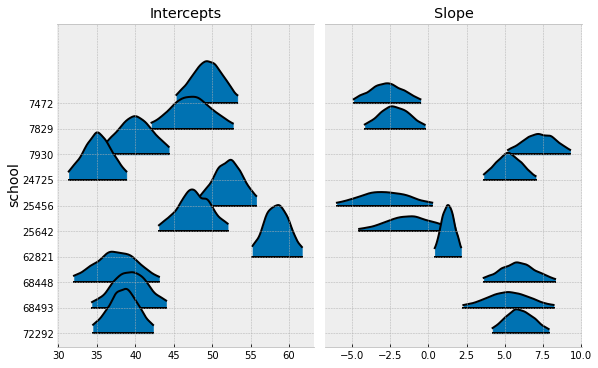

In [ ]:
fig, ax = plt.subplots(1,2, sharey=True, constrained_layout=True)

sch_ids  = sch_le.classes_[::-1]

pm.forestplot(trace, 'ridgeplot', var_names=['a'], 
              combined=True,
              ridgeplot_overlap=5,
              colors=blue,
              figsize=(5, 10), ax=ax[0])
ax[0].set_title('Intercepts')
ax[0].set_yticklabels(sch_ids)
ax[0].grid()
pm.forestplot(trace, 'ridgeplot', var_names=['b'], 
              combined=True,
              ridgeplot_overlap=5,
              colors=blue,
              figsize=(5, 10), ax=ax[1])
ax[1].set_title('Slope')
ax[1].set_yticklabels(sch_ids)
ax[1].grid()
fig.text(-0.02, 0.5, 'school', va='center', rotation='vertical', fontsize=14)

In [ ]:
def plot_posterior_regression_lines(m_p, c_p, ax=None, **kwargs):
    """
    m_p, c_p : posterior samples of slope and intercept respectively
    """
    if not ax:
        fig, ax = plt.subplots()
    
    for (m, c) in zip(m_p, c_p):
        abline(m, c, ax, **kwargs)

### Plot regression lines

We will plot all the regression lines from our posterior sample

Text(0, 0.5, 'math')

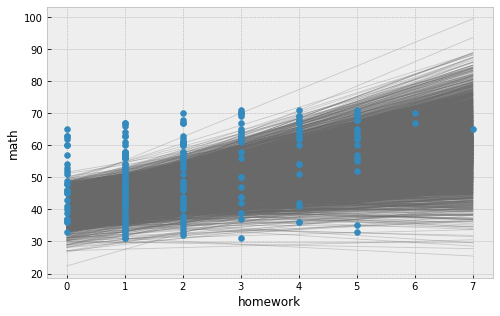

In [ ]:
fig, ax = plt.subplots()
plot_posterior_regression_lines(trace['mu_b'], trace['mu_a'], ax, color='dimgray', alpha=0.3, lw=0.8)
# abline(trace['mu_b'].mean(), trace['mu_a'].mean(), ax, color=red, linestyle='-.')
plot_data(data, ax, zorder=3)
ax.set_xlabel('homework')
ax.set_ylabel('math')

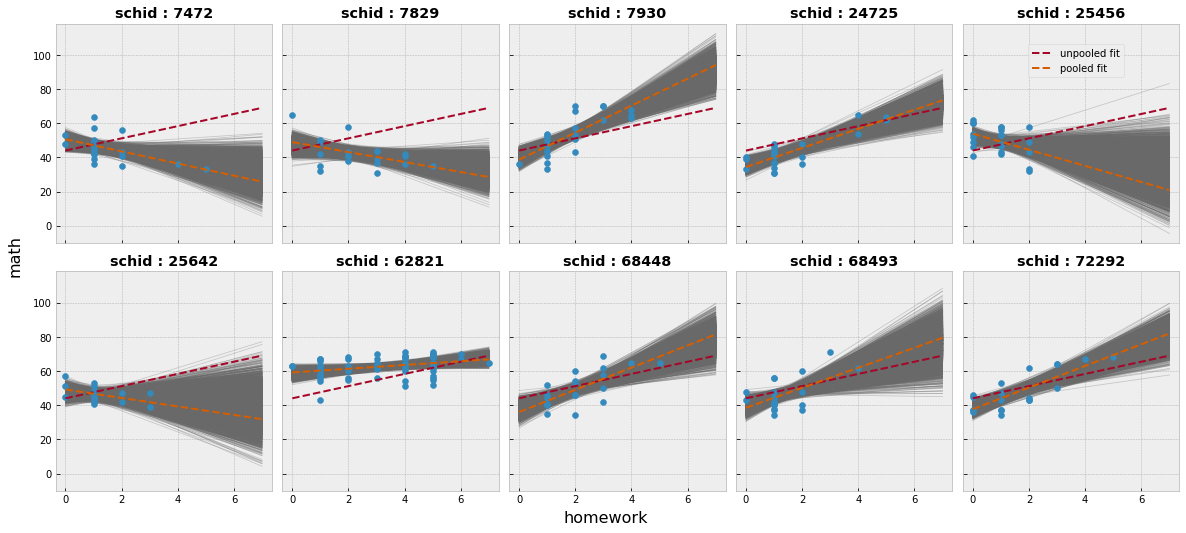

In [ ]:
def posterior_plot(df, ax, grp_id):
    grp_label = sch_le.transform([grp_id])[0]
    m_p = trace['b'][:,grp_label]
    c_p = trace['a'][:,grp_label]
    
    plot_posterior_regression_lines(m_p, c_p, ax, color='dimgray', alpha=0.3, lw=0.8)
    
    (mp, cp) = pooled_est[grp_id]
    
    plot_data(df, ax, grp_id, zorder=3)
    abline(m, c, ax, linestyle='--', color=red, label='unpooled fit', zorder=4)
    abline(mp, cp, ax, linestyle='--', color=orange, label='pooled fit', zorder=4)
    
facetgrid(posterior_plot)

Note the general higher uncertainity around groups that show a negative slope. The model implies that we must be a little more careful with decisions derived from the model on certain groups. Note with more data and lesser deviation, the bayesian model converges to the OLS model.